In [45]:
## Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import gpytorch

## Plotting 
import matplotlib.pyplot as plt 
import seaborn as sns
from figurefirst import mpl_functions

## 
import odor_stat_calculations as osc
import pandas as pd 
import os
import numpy as np

## scipy gaussian regressor 
import scipy
import scipy.stats as stats
from scipy.spatial.distance import cdist
from scipy.stats import kurtosis
from scipy.stats import ks_2samp
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import statsmodels.formula.api as smf
import linear_operator.settings as losettings
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from concurrent.futures import ProcessPoolExecutor

## bayesian optimization 
from skopt import gp_minimize
from skopt.space import Real, Categorical
from sklearn.model_selection import cross_val_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import accuracy_score, classification_report
from mpl_toolkits.axes_grid1 import make_axes_locatable 

from joblib import load, dump

### BINARY TRAINING

In [89]:
kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-3, 1e2))

def train_gp_for_file(file_path):
    # Load the data
    df = pd.read_hdf(file_path)
    if 'odor_binary' not in df.columns:
        df['odor_binary'] = df['odor'].apply(lambda x: 10 if x > 0 else 0)
    
    # Subsample the data for faster training 
    data_subsample = df.sample(frac=0.9)
    X = data_subsample[['distance_along_streakline', 'nearest_from_streakline']].values
    y = data_subsample['odor_binary'].values  
    
    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()
    
    # Scale the features
    X_scaled = scaler.fit_transform(X)
    
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3, alpha=0.1)
    gp.fit(X_scaled, y)
    
    return gp, scaler, file_path

folder_path = "/home/gorilla/An/data/Sept13Plumes/plume1/train/"
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

trained_models = {}
scalers = {}

num_cores = 50
with ProcessPoolExecutor(max_workers=num_cores) as executor:
    results = executor.map(train_gp_for_file, all_files)
    
    for gp_model, scaler, file_path in results:
        trained_models[file_path] = gp_model
        scalers[file_path] = scaler
        # print(f"Completed training for file: {file_path}")
print("Done")

/home/gorilla/An/arunavanag/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/gorilla/An/arunavanag/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/gorilla/An/arunavanag/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Done


In [88]:
# test_file_path = "/home/gorilla/An/data/Sept13Plumes/plume1/train/diag17.h5"
# test_df = pd.read_hdf(test_file_path)

# gp = trained_models[test_file_path]
# scaler = scalers[test_file_path]

# if 'odor_binary' not in test_df.columns:
#     test_df['odor_binary'] = test_df['odor'].apply(lambda x: 10 if x > 0 else 0)

# X_test = test_df[['distance_along_streakline', 'nearest_from_streakline']].values
# y_true = test_df['odor_binary'].values

# # Scale the test features
# X_test_scaled = scaler.transform(X_test)

# # Make predictions using the retrieved GP model
# y_pred_mean, y_pred_std = gp.predict(X_test_scaled, return_std=True)
# y_pred_binary = np.where(y_pred_mean > 3, 10, 0)  # Use a threshold of 5 to classify 0 or 10

# accuracy = accuracy_score(y_true, y_pred_binary)
# report = classification_report(y_true, y_pred_binary)
# print(f"Accuracy: {accuracy}")
# print(f"Classification report: {report}")

# f, axes = plt.subplots(1, 2, figsize=(10, 4))

# sc1 = axes[0].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
#                       c=test_df['odor_binary'], cmap='coolwarm', vmin=0, vmax=10)
# cbar1 = plt.colorbar(sc1, ax=axes[0])
# cbar1.set_label('True Odor Presence')
# axes[0].set_title('True Odor Presence')
# axes[0].set_xlabel('Distance Along Streakline')
# axes[0].set_ylabel('Nearest From Streakline')

# sc2 = axes[1].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
#                       c=y_pred_binary, cmap='coolwarm', vmin=0, vmax=10)
# cbar2 = plt.colorbar(sc2, ax=axes[1])
# cbar2.set_label('Predicted Odor Presence')
# axes[1].set_title('Predicted Odor Presence')
# axes[1].set_xlabel('Distance Along Streakline')

# f.tight_layout()

In [90]:
# Function to apply Box-Cox transformation
def apply_boxcox(data):
    data_min = np.min(data)
    shift = 0 
    if data_min <= 0:
        shift = np.abs(data_min) + 0.5
        data_shifted = data + shift
    else:
        data_shifted = data
    transformed_data, lambda_ = scipy.stats.boxcox(data_shifted)
    return transformed_data, lambda_, shift

# Function to calculate weighted average
def linear_decay(distance, max_distance=2):
    return max(0, (max_distance - distance) / max_distance)

def get_weighted_average(x_bin, y_bin, grid_stats, max_distance=2):
    weights_sum = 0
    weighted_sum = 0
    for dx in np.arange(-max_distance, max_distance + 0.1, 1.0):
        for dy in np.arange(-max_distance, max_distance + 0.1, 1.0):
            neighbor_x, neighbor_y = x_bin + dx, y_bin + dy
            if (neighbor_x, neighbor_y) in grid_stats:
                distance = np.sqrt(dx**2 + dy**2)
                weight = linear_decay(distance, max_distance)
                neighbor_mean, _ = grid_stats[(neighbor_x, neighbor_y)]
                weights_sum += weight
                weighted_sum += weight * neighbor_mean
    if weights_sum > 0:
        return weighted_sum / weights_sum
    else:
        return np.nan  

def train_temporal_model(df, grid_stats):
    df = df.reset_index(drop=True)
    n_bins_x = 100
    n_bins_y = 100
    x_bin_edges = np.linspace(df['distance_along_streakline'].min(), df['distance_along_streakline'].max(), n_bins_x + 1)
    y_bin_edges = np.linspace(df['nearest_from_streakline'].min(), df['nearest_from_streakline'].max(), n_bins_y + 1)
    df['x_bin'] = pd.cut(df['distance_along_streakline'], bins=x_bin_edges, labels=False, include_lowest=True, right=True)
    df['y_bin'] = pd.cut(df['nearest_from_streakline'], bins=y_bin_edges, labels=False, include_lowest=True, right=True)

    df['odor_transformed'], lambda_, shift = apply_boxcox(df.odor)

    for i in range(n_bins_x):
        for j in range(n_bins_y):
            grid_data = df[(df['x_bin'] == i) & (df['y_bin'] == j)]['odor_transformed']
            if not grid_data.empty:
                grid_mean = grid_data.mean()
                grid_std = grid_data.std()
                grid_stats[(i, j)] = (grid_mean, grid_std)
    
    return lambda_, shift, grid_stats

# Concatenate data for temporal model training
combined_df = pd.concat([pd.read_hdf(file_path) for file_path in all_files], ignore_index=True)

# Train the temporal model on combined data
grid_stats = {}
lambda_, shift, grid_stats = train_temporal_model(combined_df, grid_stats)


In [91]:
# Predicting temporal values based on spatial presence
new_test_df = pd.read_hdf("/home/gorilla/An/data/Sept13Plumes/plume1/train/diag17.h5")
new_test_df = new_test_df.reset_index(inplace=True, drop=True) 

gp = trained_models[test_file_path]
scaler = scalers[test_file_path]

# Apply spatial predictions to new data
new_X_test = new_test_df[['distance_along_streakline', 'nearest_from_streakline']].values
new_X_test_scaled = scaler.transform(new_X_test)
new_y_pred_mean, new_y_pred_std = gp.predict(new_X_test_scaled, return_std=True)
new_y_pred_binary = np.where(new_y_pred_mean > 3, 10, 0)  # Use a threshold of 3 to classify 0 or 10

n_bins_x = 100
n_bins_y = 100
x_bin_edges = np.linspace(new_test_df['distance_along_streakline'].min(), new_test_df['distance_along_streakline'].max(), n_bins_x + 1)
y_bin_edges = np.linspace(new_test_df['nearest_from_streakline'].min(), new_test_df['nearest_from_streakline'].max(), n_bins_y + 1)

new_test_df['x_bin'] = pd.cut(new_test_df['distance_along_streakline'], bins=x_bin_edges, labels=False)
new_test_df['y_bin'] = pd.cut(new_test_df['nearest_from_streakline'], bins=y_bin_edges, labels=False)

predictions = []

for index, row in new_test_df.iterrows():
    x_bin, y_bin = row['x_bin'], row['y_bin']
    if new_y_pred_binary[index] == 10:  # Only apply temporal model to locations with odor presence
        mean = get_weighted_average(x_bin, y_bin, grid_stats, max_distance=0.5)
        predictions.append(mean)
    else:
        predictions.append(np.nan)

predictions = np.array(predictions)

if shift != 0:
    predictions_original = scipy.special.inv_boxcox(predictions, lambda_) - shift
else:
    predictions_original = scipy.special.inv_boxcox(predictions, lambda_)

predictions_filled = np.nan_to_num(predictions_original, nan=0) 

# Ensure consistency in length of arrays
min_length = min(len(new_test_df['distance_along_streakline']), len(predictions_filled))
new_test_df = new_test_df.iloc[:min_length]
predictions_filled = predictions_filled[:min_length]


In [4]:

# Visualize the results
f, axes = plt.subplots(1, 2, figsize=(14, 6))

# True Odor Presence (Binary)
sc1 = axes[0].scatter(new_test_df['distance_along_streakline'], new_test_df['nearest_from_streakline'], 
                      c=new_test_df['odor'], cmap='inferno_r', vmin=0, vmax=10)
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('True Odor Presence')
axes[0].set_title('True Odor Presence')
axes[0].set_xlabel('Distance Along Streakline')
axes[0].set_ylabel('Nearest From Streakline')

# Predicted Odor Concentrations (Continuous)
sc2 = axes[1].scatter(new_test_df['distance_along_streakline'], new_test_df['nearest_from_streakline'], 
                      c=predictions_filled, cmap='inferno_r', vmin=0, vmax=10)
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Predicted Odor Concentrations')
axes[1].set_title('Predicted Odor Concentrations')
axes[1].set_xlabel('Distance Along Streakline')

f.tight_layout()
plt.show()


### ONLY USING SCIPY GPR

#### Binary Training

In [8]:
# Define the kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-3, 1e2))

# Combine all data for training a single GPR model
folder_path = "/home/gorilla/An/data/Sept13Plumes/plume1/train/"
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

combined_df = pd.concat([pd.read_hdf(file_path) for file_path in all_files], ignore_index=True)
combined_df['odor_binary'] = combined_df['odor'].apply(lambda x: 10 if x > 0 else 0)

# Subsample the combined data for faster training
data_subsample = combined_df.sample(frac=0.9)
X = data_subsample[['distance_along_streakline', 'nearest_from_streakline']].values
y = data_subsample['odor_binary'].values  

# Initialize the MinMaxScaler
use_scaler = True  # Set this to False if you don't want to use the scaler

if use_scaler:
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
else:
    scaler = None
    X_scaled = X

# Train the Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3, alpha=0.1)
gp.fit(X_scaled, y)

# Save the trained model and scaler
trained_model = gp
trained_scaler = scaler

print("Spatial Model Training Done")

In [5]:
# import joblib

# model_filename = 'trained_model_may29_binary.joblib'
# scaler_filename = 'trained_scaler_may29_binary.joblib'

# joblib.dump(trained_model, model_filename)
# if trained_scaler is not None:
#     joblib.dump(trained_scaler, scaler_filename)

# print(f"Model saved to {model_filename}")
# if trained_scaler is not None:
#     print(f"Scaler saved to {scaler_filename}")

Model saved to trained_model_may29_binary.joblib
Scaler saved to trained_scaler_may29_binary.joblib


In [3]:
# Predicting spatial values using the combined GPR model
test_file_path = "/home/gorilla/An/data/Sept13Plumes/plume1/train/diag20.h5"
new_test_df = pd.read_hdf(test_file_path)
new_test_df = new_test_df.reset_index(inplace=True, drop=True) 

new_test_df['odor_binary'] = new_test_df['odor'].apply(lambda x: 10 if x > 0 else 0)

# Use the combined trained model and scaler
gp = trained_model
scaler = trained_scaler

new_X_test = new_test_df[['distance_along_streakline', 'nearest_from_streakline']].values

if scaler is not None:
    new_X_test_scaled = scaler.transform(new_X_test)
else:
    new_X_test_scaled = new_X_test

new_y_pred_mean, new_y_pred_std = gp.predict(new_X_test_scaled, return_std=True)
new_y_pred_binary = np.where(new_y_pred_mean > 5, 10, 0)  # Use a threshold of 3 to classify 0 or 10

# Visualize the results
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.scatter(new_test_df['distance_along_streakline'], new_test_df['nearest_from_streakline'], c=new_test_df['odor_binary'], cmap='Blues', s=20)
plt.colorbar(label='True Odor Presence')
plt.title('True Odor Presence')
plt.xlabel('Distance Along Streakline')
plt.ylabel('Nearest From Streakline')

plt.subplot(1, 2, 2)
plt.scatter(new_test_df['distance_along_streakline'], new_test_df['nearest_from_streakline'], c=new_y_pred_binary, cmap='Blues', s=20)
plt.colorbar(label='Predicted Odor Presence')
plt.title('Predicted Odor Presence')
plt.xlabel('Distance Along Streakline')
plt.ylabel('Nearest From Streakline')

plt.tight_layout()
plt.show()


### Using Scipy GPR to train multiple datasets and predict continous values

In [2]:
## Windy
# df = pd.read_hdf('/home/gorilla/An/data/Sprints/LowRes/WindyForSim.h5')

## NotWindy
df = pd.read_hdf('/home/gorilla/An/data/Sprints/LowRes/WindyForSim.h5')

query = 'odor>=2'
df_new = df.query(query)

In [3]:
df_new.reset_index(inplace=True, drop=True) 

In [4]:
# query = 'odor>=2'
# df_new = df.query(query)

# df_test = df[18000:]
# df_test.reset_index(inplace=True, drop=True) 

In [25]:
# df_extracted = df[:20000]
# df_test = df_new[20000:]
df_extracted=df_new.copy()

In [26]:
far_distance_threshold = 30  # Example threshold, adjust based on your data
far_data = df_extracted[df_extracted['distance_along_streakline'] > far_distance_threshold]

In [27]:
def estimate_true_values(df, threshold, far_data):
    # Calculate the mean of the non-saturated far_data for correction
    correction_value = far_data['odor'][far_data['odor'] < threshold].mean()
    
    # Identify saturated signals
    saturated_indices = df[df['odor'] >= threshold].index
    
    # Estimate the true values for saturated signals
    df.loc[saturated_indices, 'odor'] = correction_value
    
    return df

saturation_threshold = 10  # Based on the plot

# Consider only the data from farther grids for correction

df_corrected = estimate_true_values(df_extracted, saturation_threshold, far_data)

# Ensure to correct the new_test_df as well for consistency in predictions
new_test_df = df_new.copy()
new_test_df['corrected_odor'] = estimate_true_values(new_test_df.copy(), saturation_threshold, far_data)['odor']


In [28]:
# kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-3, 1e2))
lengthscale = 0.1
alpha = 0.263

# kernel = C(1.0, (1e-2, 1e2)) * RBF(lengthscale, (1e-2, 1e1))

kernel = C(0.814**2, (1e-2, 1e2)) * RBF(lengthscale, (1e-2, 1e1))
# Training the model using the corrected data
combined_df = df_corrected

data_subsample = combined_df.sample(frac=0.9)
X = data_subsample[['distance_along_streakline', 'nearest_from_streakline']].values
y = data_subsample['odor'].values.reshape(-1, 1)

use_scaler = True  

if use_scaler:
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
else:
    scaler = None
    X_scaled = X

target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y).flatten()

# Define the kernel for the Gaussian Process Regressor
kernel = C(0.814**2, (1e-2, 1e2)) * RBF(lengthscale, (1e-2, 1e1))

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3, alpha=alpha)
gp.fit(X_scaled, y_scaled)

trained_model = gp
trained_scaler = scaler
trained_target_scaler = target_scaler
print(gp.kernel_)
print("Spatial Model Training Done")


0.92**2 * RBF(length_scale=0.01)
Spatial Model Training Done


/home/gorilla/An/arunavanag/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


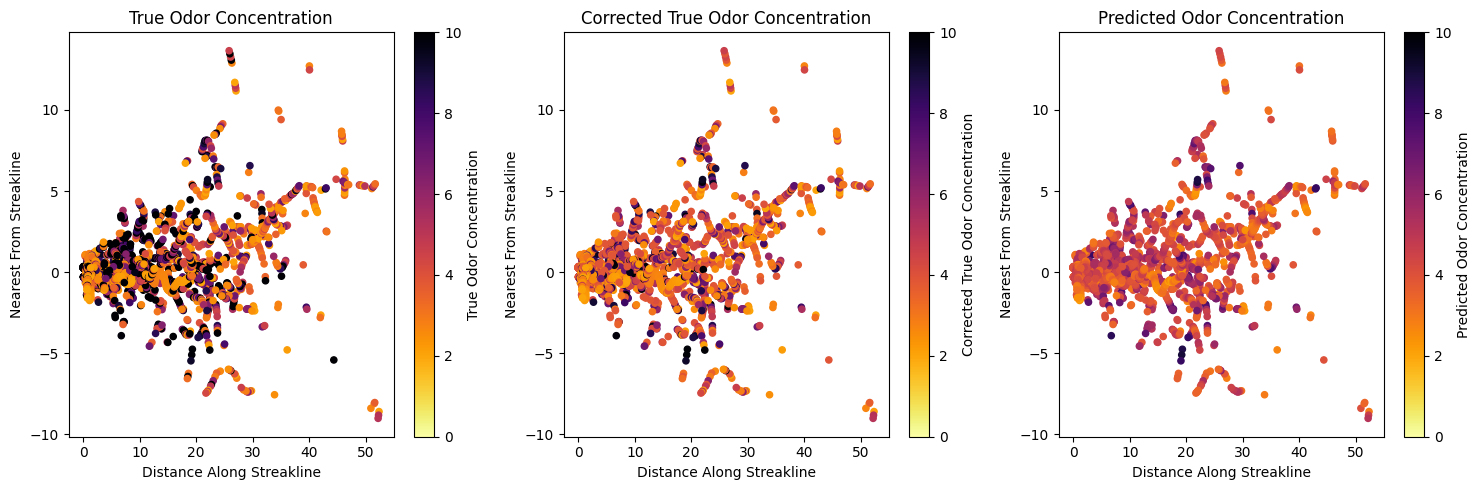

In [29]:
# Testing the model
gp = trained_model
scaler = trained_scaler
target_scaler = trained_target_scaler

new_X_test = new_test_df[['distance_along_streakline', 'nearest_from_streakline']].values

if scaler is not None:
    new_X_test_scaled = scaler.transform(new_X_test)
else:
    new_X_test_scaled = new_X_test

new_y_pred_mean, new_y_pred_std = gp.predict(new_X_test_scaled, return_std=True)

# Inverse transform the predictions to the original odor value scale
new_y_pred_mean = target_scaler.inverse_transform(new_y_pred_mean.reshape(-1, 1)).flatten()

# Apply saturation to the predicted values
new_y_pred_mean = np.clip(new_y_pred_mean, 0, saturation_threshold)

# Add the predicted values to new_test_df for comparison
new_test_df['y_predicted'] = new_y_pred_mean

# Plot the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(new_test_df['distance_along_streakline'], new_test_df['nearest_from_streakline'], c=new_test_df['odor'], cmap='inferno_r', s=20, vmin=0, vmax=10)
plt.colorbar(label='True Odor Concentration')
plt.title('True Odor Concentration')
plt.xlabel('Distance Along Streakline')
plt.ylabel('Nearest From Streakline')

plt.subplot(1, 3, 2)
plt.scatter(new_test_df['distance_along_streakline'], new_test_df['nearest_from_streakline'], c=new_test_df['corrected_odor'], cmap='inferno_r', s=20, vmin=0, vmax=10)
plt.colorbar(label='Corrected True Odor Concentration')
plt.title('Corrected True Odor Concentration')
plt.xlabel('Distance Along Streakline')
plt.ylabel('Nearest From Streakline')

plt.subplot(1, 3, 3)
plt.scatter(new_test_df['distance_along_streakline'], new_test_df['nearest_from_streakline'], c=new_y_pred_mean, cmap='inferno_r', s=20, vmin=0, vmax=10)
plt.colorbar(label='Predicted Odor Concentration')
plt.title('Predicted Odor Concentration')
plt.xlabel('Distance Along Streakline')
plt.ylabel('Nearest From Streakline')

plt.tight_layout()
plt.show()


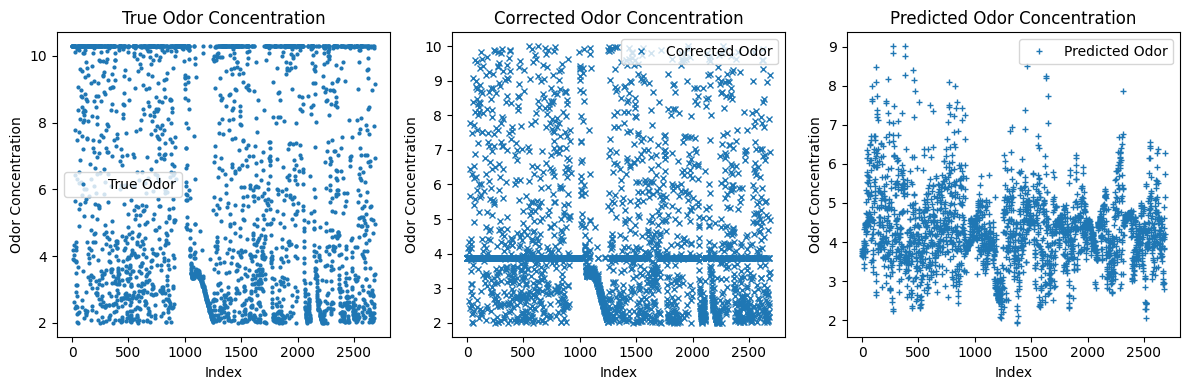

In [30]:
fig, ax = plt.subplots(1,3, figsize=(12, 4))  # Adjusting figsize for better visualization

ax[0].plot(new_test_df.index, new_test_df['odor'], 'o', markersize=2, label='True Odor')
ax[0].set_title('True Odor Concentration')
ax[0].set_xlabel('Index')
ax[0].set_ylabel('Odor Concentration')
ax[0].legend()

ax[1].plot(new_test_df.index, new_test_df['corrected_odor'], 'x', label='Corrected Odor', markersize=5)
ax[1].set_title('Corrected Odor Concentration')
ax[1].set_xlabel('Index')
ax[1].set_ylabel('Odor Concentration')
ax[1].legend()


# Plotting the predicted odor
ax[2].plot(new_test_df.index, new_y_pred_mean, '+', label='Predicted Odor', markersize=5)
ax[2].set_title('Predicted Odor Concentration')
ax[2].set_xlabel('Index')
ax[2].set_ylabel('Odor Concentration')
ax[2].legend()

fig.tight_layout()

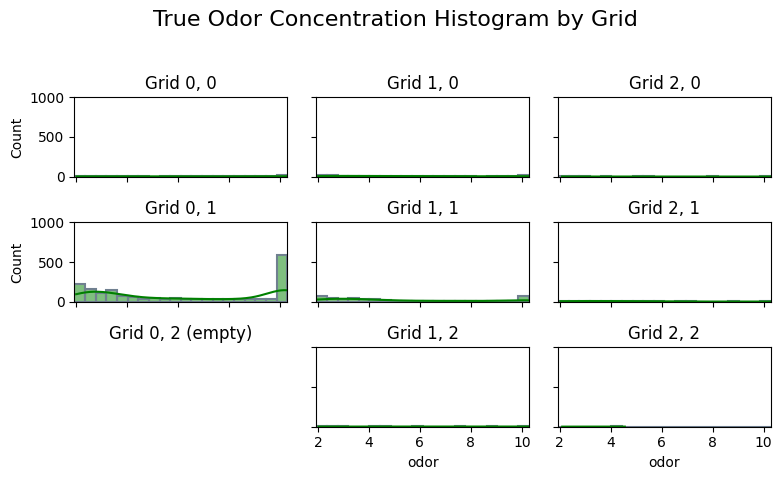

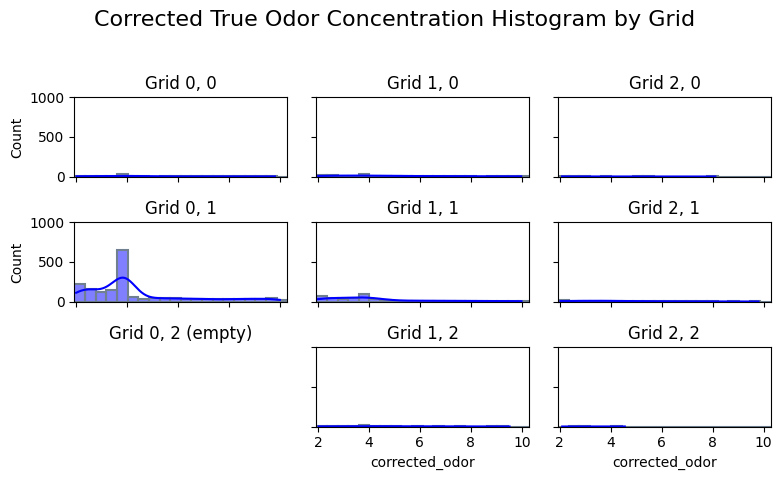

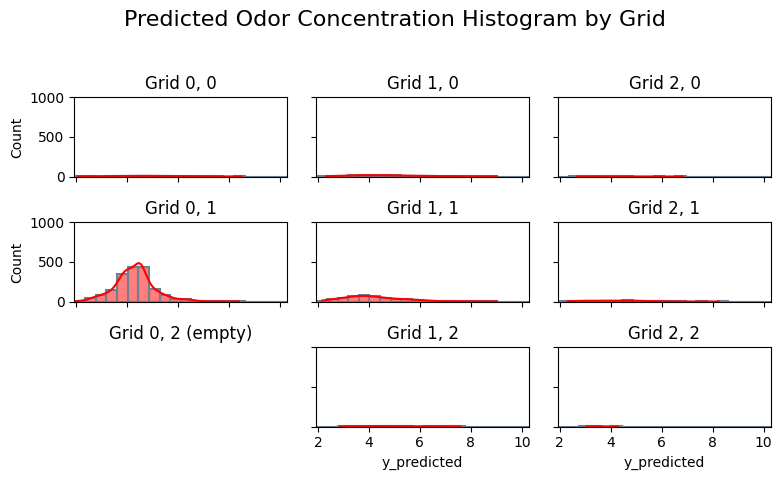

In [31]:
n_bins_x = 3
n_bins_y = 3
n_bins_hist = 20

x_bin_edges = np.linspace(new_test_df['distance_along_streakline'].min(), new_test_df['distance_along_streakline'].max(), n_bins_x + 1)
y_bin_edges = np.linspace(new_test_df['nearest_from_streakline'].min(), new_test_df['nearest_from_streakline'].max(), n_bins_y + 1)

new_test_df['x_bin'] = pd.cut(new_test_df['distance_along_streakline'], bins=x_bin_edges, labels=False)
new_test_df['y_bin'] = pd.cut(new_test_df['nearest_from_streakline'], bins=y_bin_edges, labels=False)

global_min = new_test_df[['odor', 'corrected_odor', 'y_predicted']].min().min()
global_max = new_test_df[['odor', 'corrected_odor', 'y_predicted']].max().max()
bin_edges = np.linspace(global_min, global_max, n_bins_hist + 1)

specific_x_min = global_min
specific_x_max = global_max

fig, axes = plt.subplots(n_bins_y, n_bins_x, figsize=(8, 5), sharex=True, sharey=True)
for i in range(n_bins_x):
    for j in range(n_bins_y):
        grid_data = new_test_df[(new_test_df['x_bin'] == i) & (new_test_df['y_bin'] == j)]['odor']
        ax = axes[j, i]  # Note the reversed order of j and i to match the grid layout
        if not grid_data.empty:
            sns.histplot(grid_data, bins=bin_edges, kde=True, ax=ax, color='green', edgecolor='slategray', linewidth=1.5)
            ax.set_xlim([specific_x_min, specific_x_max])
            ax.set_ylim([0, 1000])  # Adjusted to fit the actual data range
            ax.set_title(f'Grid {i}, {j}')
        else:
            ax.set_title(f'Grid {i}, {j} (empty)')
            ax.axis('off')

fig.suptitle('True Odor Concentration Histogram by Grid', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

fig, axes = plt.subplots(n_bins_y, n_bins_x, figsize=(8, 5), sharex=True, sharey=True)
for i in range(n_bins_x):
    for j in range(n_bins_y):
        grid_data = new_test_df[(new_test_df['x_bin'] == i) & (new_test_df['y_bin'] == j)]['corrected_odor']
        ax = axes[j, i]  
        if not grid_data.empty:
            sns.histplot(grid_data, bins=bin_edges, kde=True, ax=ax, color='blue', edgecolor='slategray', linewidth=1.5)
            ax.set_xlim([specific_x_min, specific_x_max])
            ax.set_ylim([0, 1000])  
            ax.set_title(f'Grid {i}, {j}')
        else:
            ax.set_title(f'Grid {i}, {j} (empty)')
            ax.axis('off')

fig.suptitle('Corrected True Odor Concentration Histogram by Grid', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

fig, axes = plt.subplots(n_bins_y, n_bins_x, figsize=(8, 5), sharex=True, sharey=True)
for i in range(n_bins_x):
    for j in range(n_bins_y):
        grid_data = new_test_df[(new_test_df['x_bin'] == i) & (new_test_df['y_bin'] == j)]['y_predicted']
        ax = axes[j, i]  
        if not grid_data.empty:
            sns.histplot(grid_data, bins=bin_edges, kde=True, ax=ax, color='red', edgecolor='slategray', linewidth=1.5)
            ax.set_xlim([specific_x_min, specific_x_max])
            ax.set_ylim([0, 1000])  
            ax.set_title(f'Grid {i}, {j}')
        else:
            ax.set_title(f'Grid {i}, {j} (empty)')
            ax.axis('off')

fig.suptitle('Predicted Odor Concentration Histogram by Grid', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Method 2

In [87]:
df = pd.read_hdf('/home/gorilla/An/data/Sprints/LowRes/WindyForSim.h5')
query = 'odor>=2'
df_extracted = df.query(query)
df_extracted.reset_index(inplace=True, drop=True) 
far_distance_threshold = 10 
far_data = df_extracted[df_extracted['distance_along_streakline'] > far_distance_threshold]

In [88]:
saturation_threshold = 10 

def fit_exponential_distribution(far_data, threshold):
    non_saturated_data = far_data[far_data['odor'] < threshold]['odor']
    loc, scale = stats.expon.fit(non_saturated_data)
    return loc, scale

loc, scale = fit_exponential_distribution(far_data, saturation_threshold)

# Estimate values with exponential distribution
def generate_values_above_threshold(loc, scale, threshold, size):
    cdf_threshold = stats.expon.cdf(threshold, loc=loc, scale=scale)
    uniform_values = np.random.uniform(cdf_threshold, 1, size)
    values_above_threshold = stats.expon.ppf(uniform_values, loc=loc, scale=scale)
    return values_above_threshold

def estimate_values_with_exponential_distribution(df, threshold, loc, scale):
    saturated_indices = df[df['odor'] >= threshold].index
    estimated_values = generate_values_above_threshold(loc, scale, threshold, len(saturated_indices))
    df.loc[saturated_indices, 'odor'] = estimated_values
    return df

# Correct the data
df_corrected = estimate_values_with_exponential_distribution(df_extracted.copy(), saturation_threshold, loc, scale)
new_test_df = df_extracted.copy()
new_test_df['corrected_odor'] = estimate_values_with_exponential_distribution(new_test_df.copy(), saturation_threshold, loc, scale)['odor']


In [79]:
# saturation_threshold = 10 
# def fit_exponential_distribution(far_data, threshold):
#     # Filter non-saturated data
#     non_saturated_data = far_data[far_data['odor'] < threshold]['odor']
#     loc, scale = stats.expon.fit(non_saturated_data)
#     return loc, scale

# loc, scale = fit_exponential_distribution(far_data, saturation_threshold)
# def estimate_values_with_exponential_distribution(df, threshold, loc, scale):
#     saturated_indices = df[df['odor'] >= threshold].index
#     estimated_values = stats.expon.rvs(loc=loc, scale=scale, size=len(saturated_indices))
#     df.loc[saturated_indices, 'odor'] = estimated_values
    
#     return df

# df_corrected = estimate_values_with_exponential_distribution(df_extracted.copy(), saturation_threshold, loc, scale)

# new_test_df = df_new.copy()
# new_test_df['corrected_odor'] = estimate_values_with_exponential_distribution(new_test_df.copy(), saturatidf_newon_threshold, loc, scale)['odor']


In [80]:
# new_test_df = df[15000:]
# new_test_df['corrected_odor'] = estimate_values_with_exponential_distribution(new_test_df.copy(), saturation_threshold, loc, scale)['odor']


In [89]:
# kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-3, 1e2))
lengthscale = 0.1
alpha = 0.263

# kernel = C(1.0, (1e-2, 1e2)) * RBF(lengthscale, (1e-2, 1e1))

kernel = C(0.814**2, (1e-2, 1e2)) * RBF(lengthscale, (1e-2, 1e1))
combined_df = df_corrected

data_subsample = combined_df.sample(frac=0.9)
X = data_subsample[['distance_along_streakline', 'nearest_from_streakline']].values
y = data_subsample['odor'].values.reshape(-1, 1)

use_scaler = True  

if use_scaler:
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
else:
    scaler = None
    X_scaled = X

target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y).flatten()

# Define the kernel for the Gaussian Process Regressor
kernel = C(0.814**2, (1e-2, 1e2)) * RBF(lengthscale, (1e-2, 1e1))
alpha = 0.263

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3, alpha=alpha)
gp.fit(X_scaled, y_scaled)

trained_model = gp
trained_scaler = scaler
trained_target_scaler = target_scaler
print(gp.kernel_)
print("Spatial Model Training Done")


0.824**2 * RBF(length_scale=0.01)
Spatial Model Training Done


/home/gorilla/An/arunavanag/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


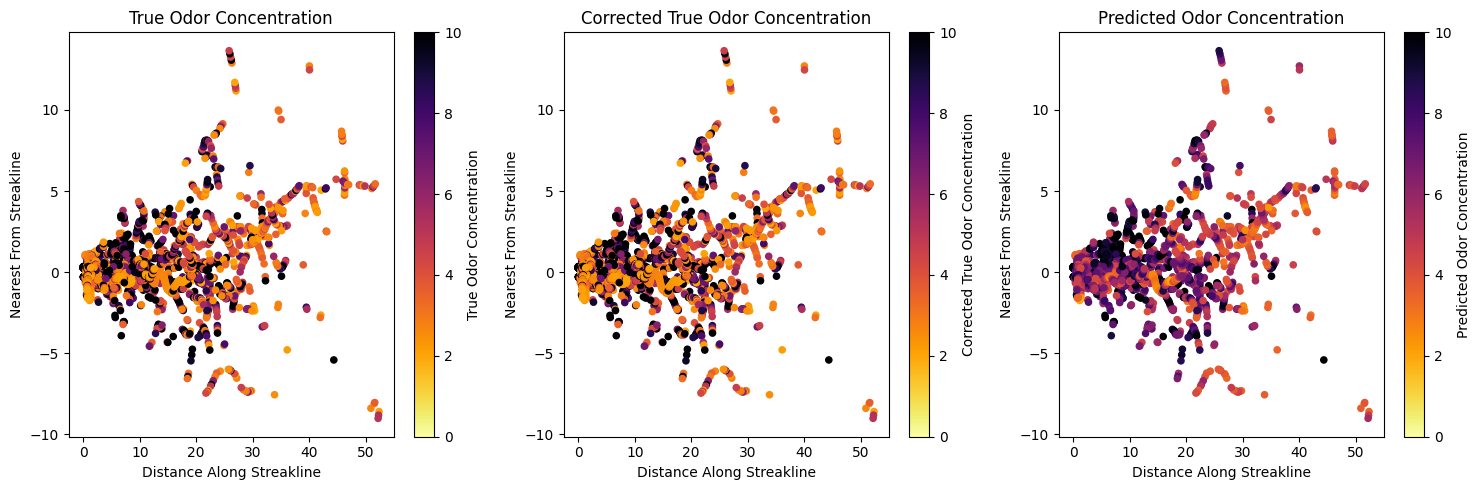

In [90]:
gp = trained_model
scaler = trained_scaler
target_scaler = trained_target_scaler

new_X_test = new_test_df[['distance_along_streakline', 'nearest_from_streakline']].values

if scaler is not None:
    new_X_test_scaled = scaler.transform(new_X_test)
else:
    new_X_test_scaled = new_X_test

new_y_pred_mean, new_y_pred_std = gp.predict(new_X_test_scaled, return_std=True)

# Inverse transform the predictions to the original odor value scale
new_y_pred_mean = target_scaler.inverse_transform(new_y_pred_mean.reshape(-1, 1)).flatten()

# Apply saturation to the predicted values
new_y_pred_mean = np.clip(new_y_pred_mean, 0, saturation_threshold)

# Add the predicted values to new_test_df for comparison
new_test_df['y_predicted'] = new_y_pred_mean

# Plot the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(new_test_df['distance_along_streakline'], new_test_df['nearest_from_streakline'], c=new_test_df['odor'], cmap='inferno_r', s=20, vmin=0, vmax=10)
plt.colorbar(label='True Odor Concentration')
plt.title('True Odor Concentration')
plt.xlabel('Distance Along Streakline')
plt.ylabel('Nearest From Streakline')

plt.subplot(1, 3, 2)
plt.scatter(new_test_df['distance_along_streakline'], new_test_df['nearest_from_streakline'], c=new_test_df['corrected_odor'], cmap='inferno_r', s=20, vmin=0, vmax=10)
plt.colorbar(label='Corrected True Odor Concentration')
plt.title('Corrected True Odor Concentration')
plt.xlabel('Distance Along Streakline')
plt.ylabel('Nearest From Streakline')

plt.subplot(1, 3, 3)
plt.scatter(new_test_df['distance_along_streakline'], new_test_df['nearest_from_streakline'], c=new_y_pred_mean, cmap='inferno_r', s=20, vmin=0, vmax=10)
plt.colorbar(label='Predicted Odor Concentration')
plt.title('Predicted Odor Concentration')
plt.xlabel('Distance Along Streakline')
plt.ylabel('Nearest From Streakline')

plt.tight_layout()
plt.show()

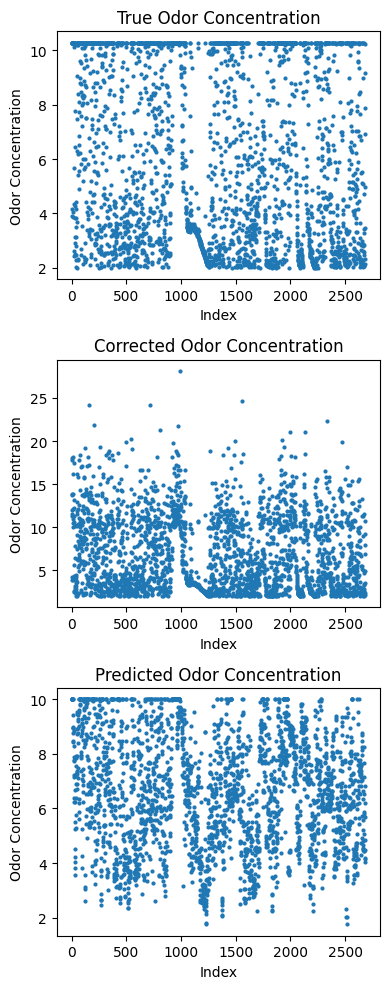

In [95]:
fig, ax = plt.subplots(3,1, figsize=(4, 10))  # Adjusting figsize for better visualization

ax[0].plot(new_test_df.index, new_test_df['odor'], 'o', markersize=2, label='True Odor')
ax[0].set_title('True Odor Concentration')
ax[0].set_xlabel('Index')
ax[0].set_ylabel('Odor Concentration')
# ax[0].legend()

ax[1].plot(new_test_df.index, new_test_df['corrected_odor'], 'o', label='Corrected Odor', markersize=2)
ax[1].set_title('Corrected Odor Concentration')
ax[1].set_xlabel('Index')
ax[1].set_ylabel('Odor Concentration')
# ax[1].legend()


# Plotting the predicted odor
ax[2].plot(new_test_df.index, new_test_df.y_predicted, 'o', label='Predicted Odor', markersize=2)
ax[2].set_title('Predicted Odor Concentration')
ax[2].set_xlabel('Index')
ax[2].set_ylabel('Odor Concentration')
# ax[2].legend()

fig.tight_layout()

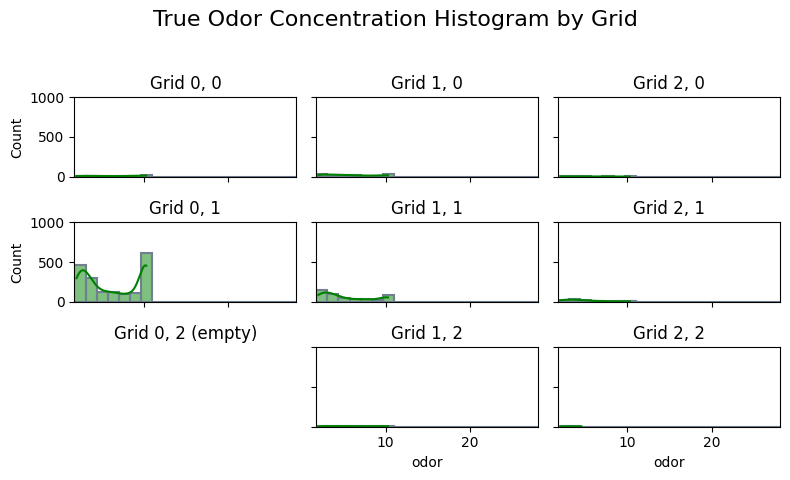

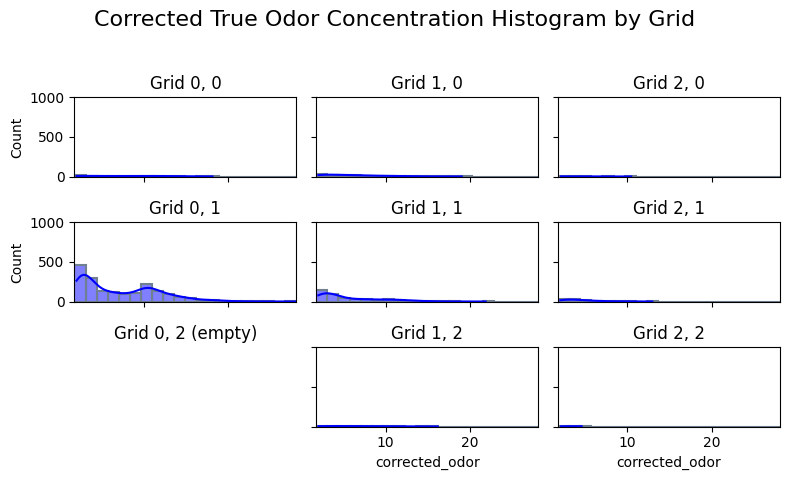

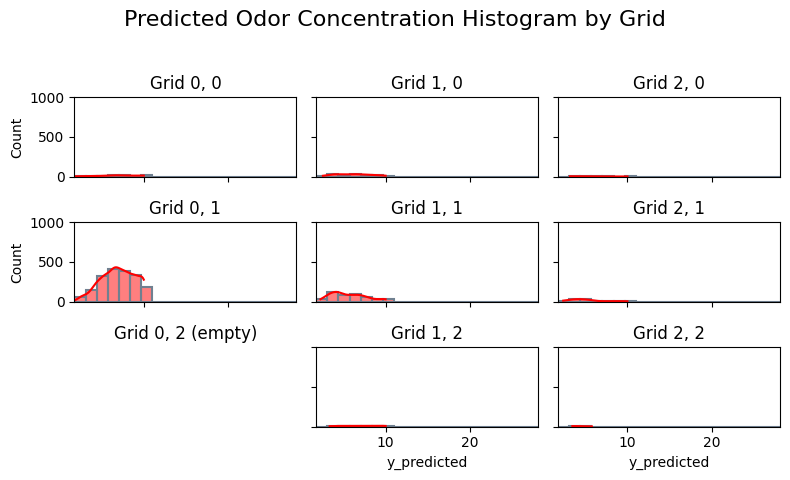

In [92]:
# Define the number of bins for the grid
n_bins_x = 3
n_bins_y = 3
n_bins_hist = 20

x_bin_edges = np.linspace(new_test_df['distance_along_streakline'].min(), new_test_df['distance_along_streakline'].max(), n_bins_x + 1)
y_bin_edges = np.linspace(new_test_df['nearest_from_streakline'].min(), new_test_df['nearest_from_streakline'].max(), n_bins_y + 1)

new_test_df['x_bin'] = pd.cut(new_test_df['distance_along_streakline'], bins=x_bin_edges, labels=False)
new_test_df['y_bin'] = pd.cut(new_test_df['nearest_from_streakline'], bins=y_bin_edges, labels=False)
# Determine global range for histogram bins
global_min = new_test_df[['odor', 'corrected_odor', 'y_predicted']].min().min()
global_max = new_test_df[['odor', 'corrected_odor', 'y_predicted']].max().max()
bin_edges = np.linspace(global_min, global_max, n_bins_hist + 1)

# Define specific x-axis limits
specific_x_min = global_min
specific_x_max = global_max
ylim=[0,1000]
# Plot histograms for true odor concentration
fig, axes = plt.subplots(n_bins_y, n_bins_x, figsize=(8, 5), sharex=True, sharey=True)
for i in range(n_bins_x):
    for j in range(n_bins_y):
        grid_data = new_test_df[(new_test_df['x_bin'] == i) & (new_test_df['y_bin'] == j)]['odor']
        ax = axes[j, i]  # Note the reversed order of j and i to match the grid layout
        if not grid_data.empty:
            sns.histplot(grid_data, bins=bin_edges, kde=True, ax=ax, color='green', edgecolor='slategray', linewidth=1.5)
            ax.set_xlim([specific_x_min, specific_x_max])
            ax.set_ylim(ylim)  # Adjusted to fit the actual data range
            ax.set_title(f'Grid {i}, {j}')
        else:
            ax.set_title(f'Grid {i}, {j} (empty)')
            ax.axis('off')

fig.suptitle('True Odor Concentration Histogram by Grid', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Plot histograms for corrected true odor concentration
fig, axes = plt.subplots(n_bins_y, n_bins_x, figsize=(8, 5), sharex=True, sharey=True)
for i in range(n_bins_x):
    for j in range(n_bins_y):
        grid_data = new_test_df[(new_test_df['x_bin'] == i) & (new_test_df['y_bin'] == j)]['corrected_odor']
        ax = axes[j, i]  # Note the reversed order of j and i to match the grid layout
        if not grid_data.empty:
            sns.histplot(grid_data, bins=bin_edges, kde=True, ax=ax, color='blue', edgecolor='slategray', linewidth=1.5)
            ax.set_xlim([specific_x_min, specific_x_max])
            ax.set_ylim(ylim)  # Adjusted to fit the actual data range
            ax.set_title(f'Grid {i}, {j}')
        else:
            ax.set_title(f'Grid {i}, {j} (empty)')
            ax.axis('off')

fig.suptitle('Corrected True Odor Concentration Histogram by Grid', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Plot histograms for predicted odor concentration
fig, axes = plt.subplots(n_bins_y, n_bins_x, figsize=(8, 5), sharex=True, sharey=True)
for i in range(n_bins_x):
    for j in range(n_bins_y):
        grid_data = new_test_df[(new_test_df['x_bin'] == i) & (new_test_df['y_bin'] == j)]['y_predicted']
        ax = axes[j, i]  # Note the reversed order of j and i to match the grid layout
        if not grid_data.empty:
            sns.histplot(grid_data, bins=bin_edges, kde=True, ax=ax, color='red', edgecolor='slategray', linewidth=1.5)
            ax.set_xlim([specific_x_min, specific_x_max])
            ax.set_ylim(ylim)  # Adjusted to fit the actual data range
            ax.set_title(f'Grid {i}, {j}')
        else:
            ax.set_title(f'Grid {i}, {j} (empty)')
            ax.axis('off')

fig.suptitle('Predicted Odor Concentration Histogram by Grid', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [115]:
new_test_df.keys()

Index(['master_time', 'xsrc', 'ysrc', 'lat', 'lon', 'odor', 'trisonica_u',
       'trisonica_v', 'trisonica_pressure', 'trisonica_temperature',
       'gps_linear_x', 'gps_linear_y', 'gps_linear_z', 'imu_angular_x',
       'imu_angular_y', 'imu_angular_z', 'imu_linear_acc_x',
       'imu_linear_acc_y', 'imu_linear_acc_z', 'U', 'V', 'D', 'S2', 'time',
       'corrected_u', 'corrected_v', 'distance_from_source', 'odorsim',
       'nearest_from_streakline', 'relative_parallel_comp',
       'relative_perpendicular_comp', 'sign_encounter', 'ysign', 'xsign',
       'distance_along_streakline', 'corrected_odor', 'y_predicted', 'x_bin',
       'y_bin'],
      dtype='object')

In [188]:
# import joblib
# # Save the trained model and scalers
# model_filename = 'trained_model_jun3_modified_model1.joblib'
# scaler_filename = 'trained_model_jun3_modified_scaler1.joblib'
# target_scaler_filename = 'trained_model_jun3_modified_target_scaler1.joblib'

# joblib.dump(trained_model, model_filename)
# if trained_scaler is not None:
#     joblib.dump(trained_scaler, scaler_filename)
# joblib.dump(trained_target_scaler, target_scaler_filename)

# print(f"Model saved to {model_filename}")
# if trained_scaler is not None:
#     print(f"Scaler saved to {scaler_filename}")
# print(f"Target scaler saved to {target_scaler_filename}")

In [9]:
# x1 = np.linspace(min(X[:, 0]), max(X[:, 0]), 25)
# x2 = np.linspace(min(X[:, 1]), max(X[:, 1]), 25)
# X1, X2 = np.meshgrid(x1, x2)
# X_grid = np.vstack([X1.ravel(), X2.ravel()]).T

# if scaler is not None:
#     X_grid_scaled = scaler.transform(X_grid)
# else:
#     X_grid_scaled = X_grid

# y_pred_scaled, y_std = gp.predict(X_grid_scaled, return_std=True)

# y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# # Visualization
# plt.figure(figsize=(8, 4))
# plt.contourf(X1, X2, y_pred.reshape(X1.shape), levels=100, cmap='viridis')
# plt.colorbar(label='Predicted Odor Concentration')
# plt.contour(X1, X2, y_pred.reshape(X1.shape), levels=1, colors='k', linewidths=0.5)

# plt.title('alpha='+str(alpha)+' lengthscale='+str(lengthscale))
# plt.xlabel('Distance Along Streakline')
# plt.ylabel('Nearest From Streakline')
# plt.show()

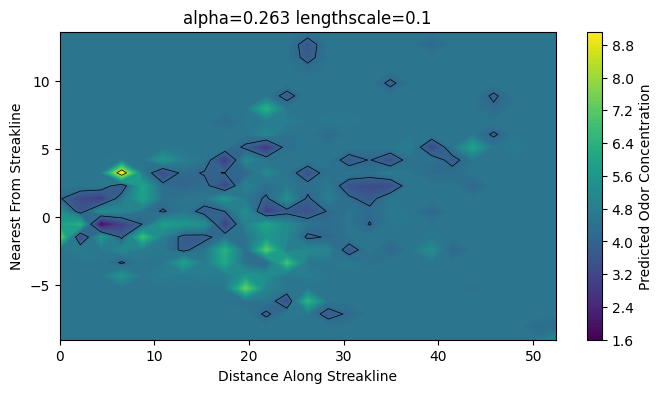

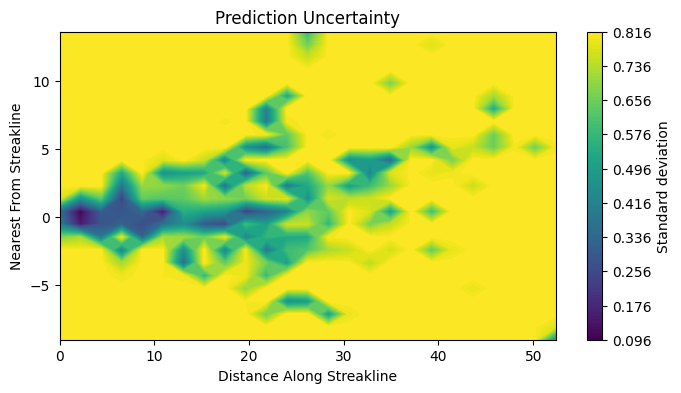

In [116]:
x1 = np.linspace(min(X[:, 0]), max(X[:, 0]), 25)
x2 = np.linspace(min(X[:, 1]), max(X[:, 1]), 25)
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.vstack([X1.ravel(), X2.ravel()]).T

if scaler is not None:
    X_grid_scaled = scaler.transform(X_grid)
else:
    X_grid_scaled = X_grid

y_pred_scaled, y_std = gp.predict(X_grid_scaled, return_std=True)

y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

plt.figure(figsize=(8, 4))
plt.contourf(X1, X2, y_pred.reshape(X1.shape), levels=100, cmap='viridis')
plt.colorbar(label='Predicted Odor Concentration')
plt.contour(X1, X2, y_pred.reshape(X1.shape), levels=1, colors='k', linewidths=0.5)
plt.title('alpha=' + str(alpha) + ' lengthscale=' + str(lengthscale))
plt.xlabel('Distance Along Streakline')
plt.ylabel('Nearest From Streakline')
plt.show()

# Visualization for prediction uncertainty
plt.figure(figsize=(8, 4))
plt.contourf(X1, X2, y_std.reshape(X1.shape), cmap='viridis', levels=100)
plt.colorbar(label='Standard deviation')
plt.title('Prediction Uncertainty')
plt.xlabel('Distance Along Streakline')
plt.ylabel('Nearest From Streakline')
plt.show()


In [55]:
# x1 = np.linspace(min(X[:, 0]), max(X[:, 0]), 100)
# x2 = np.linspace(min(X[:, 1]), max(X[:, 1]), 100)
# X1, X2 = np.meshgrid(x1, x2)
# X_grid = np.vstack([X1.ravel(), X2.ravel()]).T

# if scaler is not None:
#     X_grid_scaled = scaler.transform(X_grid)
# else:
#     X_grid_scaled = X_grid

# # Predict using the trained model
# y_pred_scaled, y_std = gp.predict(X_grid_scaled, return_std=True)

# # Inverse transform the predictions
# y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# # Contour plot for predicted data
# contour = ax.contourf(X1, X2, y_pred.reshape(X1.shape), levels=100, cmap='viridis')
# fig.colorbar(contour, ax=ax, label='Predicted Odor Concentration')
# ax.contour(X1, X2, y_pred.reshape(X1.shape), levels=10, colors='k', linewidths=0.5)

# # Overlay the actual data points
# ax.scatter(X[:, 0], X[:, 1], c='b',alpha=0.5, edgecolor='w', marker='o', s=50, label='Actual Data Points')

# ax.set_title('GP Predicted Odor Concentration with Actual Data Points')
# ax.set_xlabel('Distance Along Streakline')
# ax.set_ylabel('Nearest From Streakline')
# # ax.legend()
# fig.tight_layout()


In [56]:
# import joblib

# model_filename = 'trained_model_may29_cont.joblib'
# scaler_filename = 'trained_scaler_may29_cont.joblib'

# joblib.dump(trained_model, model_filename)
# if trained_scaler is not None:
#     joblib.dump(trained_scaler, scaler_filename)

# print(f"Model saved to {model_filename}")
# if trained_scaler is not None:
#     print(f"Scaler saved to {scaler_filename}")

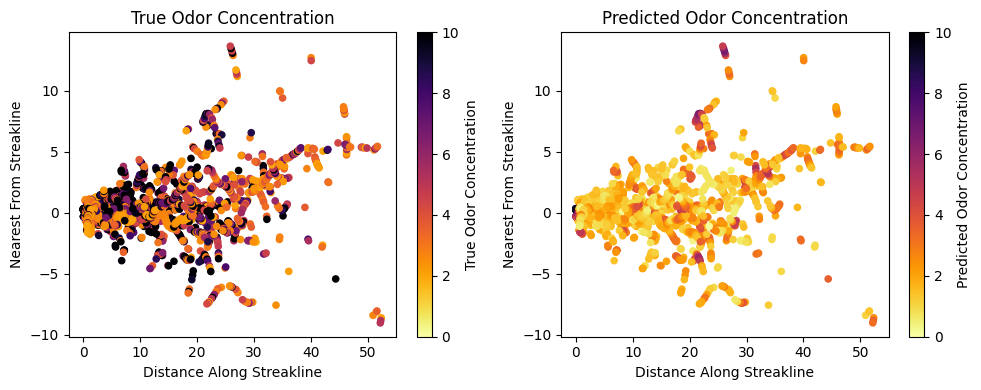

In [24]:
# test_file_path = "/home/gorilla/An/data/Sept13Plumes/plume1/train/diag17.h5"
# test_file_path = "/home/gorilla/An/data/Sept13Plumes/plume1/diag10.h5"
# new_test_df = pd.read_hdf(test_file_path)
# new_test_df = new_test_df.reset_index(drop=True)
new_test_df = df_new
new_test_df.reset_index(inplace=True, drop=True) 
gp = trained_model
scaler = trained_scaler
target_scaler = trained_target_scaler

new_X_test = new_test_df[['distance_along_streakline', 'nearest_from_streakline']].values

if scaler is not None:
    new_X_test_scaled = scaler.transform(new_X_test)
else:
    new_X_test_scaled = new_X_test

new_y_pred_mean, new_y_pred_std = gp.predict(new_X_test_scaled, return_std=True)

# Inverse transform the predictions to the original odor value scale
new_y_pred_mean = target_scaler.inverse_transform(new_y_pred_mean.reshape(-1, 1)).flatten()

# Clip the predictions to be within the range [0, 10]
new_y_pred_mean = np.clip(new_y_pred_mean, 0, 10)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(new_test_df['distance_along_streakline'], new_test_df['nearest_from_streakline'], c=new_test_df['odor'], cmap='inferno_r', s=20, vmin=0, vmax=10)
plt.colorbar(label='True Odor Concentration')
plt.title('True Odor Concentration')
plt.xlabel('Distance Along Streakline')
plt.ylabel('Nearest From Streakline')

plt.subplot(1, 2, 2)
plt.scatter(new_test_df['distance_along_streakline'], new_test_df['nearest_from_streakline'], c=new_y_pred_mean, cmap='inferno_r', s=20, vmin=0, vmax=10)
plt.colorbar(label='Predicted Odor Concentration')
plt.title('Predicted Odor Concentration')
plt.xlabel('Distance Along Streakline')
plt.ylabel('Nearest From Streakline')

plt.tight_layout()
plt.show()


In [25]:
tdf = new_test_df.copy()

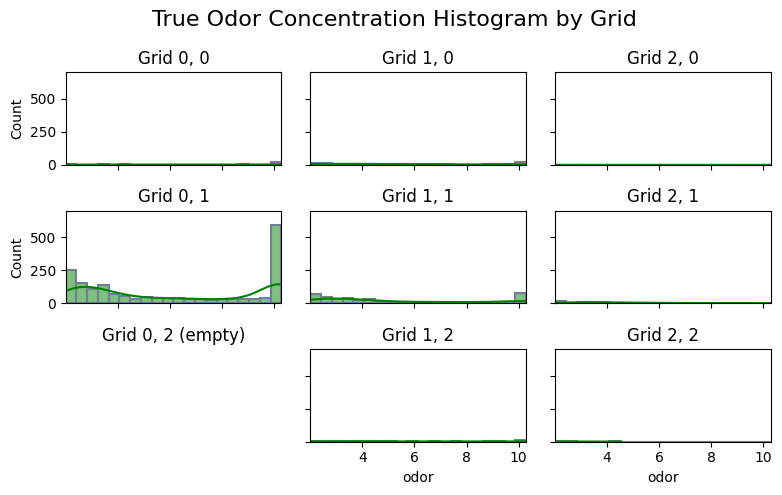

In [14]:
n_bins_x = 3
n_bins_y = 3
n_bins_hist = 20  

# Calculate bin edges for the grid
x_bin_edges = np.linspace(tdf['distance_along_streakline'].min(), tdf['distance_along_streakline'].max(), n_bins_x + 1)
y_bin_edges = np.linspace(tdf['nearest_from_streakline'].min(), tdf['nearest_from_streakline'].max(), n_bins_y + 1)

# Assign grid bin numbers to each data point
tdf['x_bin'] = pd.cut(tdf['distance_along_streakline'], bins=x_bin_edges, labels=False)
tdf['y_bin'] = pd.cut(tdf['nearest_from_streakline'], bins=y_bin_edges, labels=False)

# Determine global range for histogram bins
global_min = tdf['odor'].min()
global_max = tdf['odor'].max()
bin_edges = np.linspace(global_min, global_max, n_bins_hist + 1)

# Define specific x-axis limits
specific_x_min = global_min
specific_x_max = global_max

# Plot histograms for true odor concentration
fig, axes = plt.subplots(n_bins_y, n_bins_x, figsize=(8, 5), sharex=True, sharey=True)
for i in range(n_bins_x):
    for j in range(n_bins_y):
        grid_data = tdf[(tdf['x_bin'] == i) & (tdf['y_bin'] == j)]['odor']
        ax = axes[j, i]  # Note the reversed order of j and i to match the grid layout
        if not grid_data.empty:
            sns.histplot(grid_data, bins=bin_edges, kde=True, ax=ax, color='green', edgecolor='slategray', linewidth=1.5)
            ax.set_xlim([specific_x_min, specific_x_max])
            ax.set_ylim([0, 700])
            ax.set_title(f'Grid {i}, {j}')
        else:
            ax.set_title(f'Grid {i}, {j} (empty)')
            ax.axis('off')


fig.suptitle('True Odor Concentration Histogram by Grid', fontsize=16)
fig.tight_layout()

In [28]:
tdf['y_predicted']=new_y_pred_mean

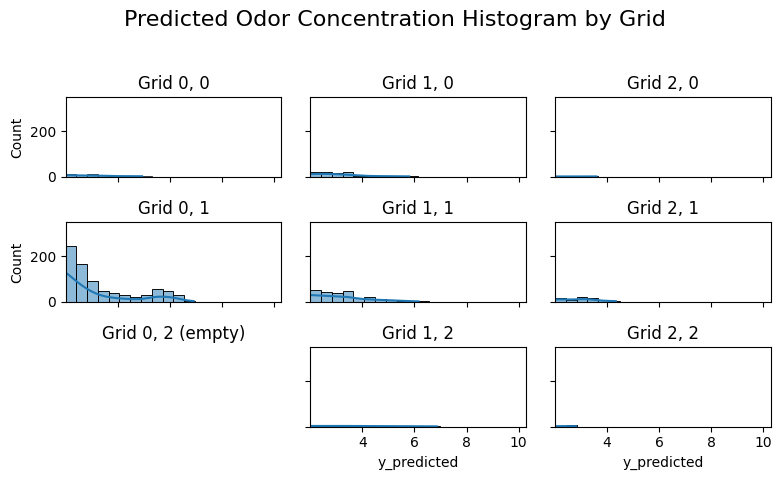

In [16]:
n_bins_hist = 20 
# bin_edges = np.linspace(0, 3, n_bins_hist + 1)
x_lim = (global_min, global_max)

# Plot histograms for predicted odor concentration
fig, axes = plt.subplots(n_bins_y, n_bins_x, figsize=(8, 5), sharex=True, sharey=True)
for i in range(n_bins_x):
    for j in range(n_bins_y):
        grid_data = tdf[(tdf['x_bin'] == i) & (tdf['y_bin'] == j)]['y_predicted']
        ax = axes[j, i]  # Note the reversed order of j and i to match the grid layout
        if not grid_data.empty:
            sns.histplot(grid_data, bins=bin_edges, kde=True, ax=ax)
            ax.set_xlim(x_lim)
            ax.set_ylim([0, 350]) 
            ax.set_title(f'Grid {i}, {j}')
        else:
            ax.set_title(f'Grid {i}, {j} (empty)')
            ax.axis('off')

fig.suptitle('Predicted Odor Concentration Histogram by Grid', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


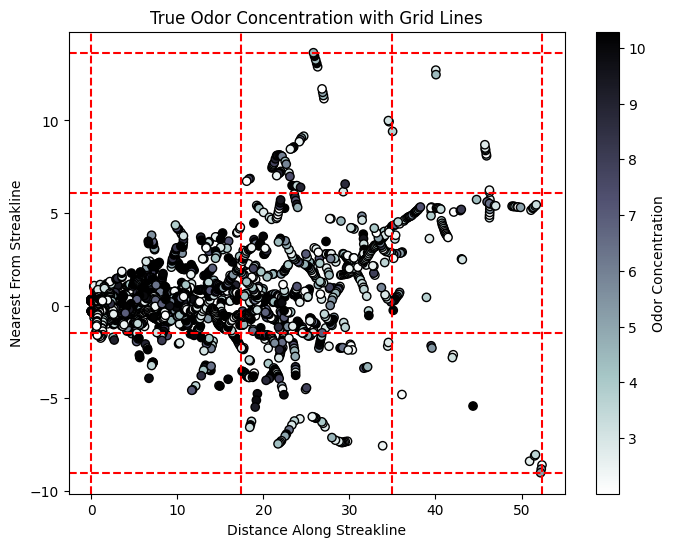

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(tdf['distance_along_streakline'], tdf['nearest_from_streakline'], c=tdf['odor'], cmap='bone_r', edgecolor='k')
plt.colorbar(scatter, label='Odor Concentration')

# Draw vertical and horizontal lines for the grid
for xc in x_bin_edges:
    ax.axvline(x=xc, color='r', linestyle='--')
for yc in y_bin_edges:
    ax.axhline(y=yc, color='r', linestyle='--')

ax.set_title('True Odor Concentration with Grid Lines')
ax.set_xlabel('Distance Along Streakline')
ax.set_ylabel('Nearest From Streakline')
plt.show()

### CROSS VALIDATION TECHNIQUE FOR PARAMETER TUNING

In [56]:
# # from sklearn.gaussian_process import GaussianProcessRegressor
# # from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
# from sklearn.model_selection import GridSearchCV

# # Define the kernel with initial parameters
# kernel = C(1.0, (1e-2, 1e2)) * RBF(1, (1e-2, 1e1))

# # Grid of parameters to search
# param_grid = {
#     'kernel': [C(1.0, (1e-2, 1e2)) * RBF(l, (1e-2, 1e1)) for l in [0.1, 1, 10]],
#     'alpha': [1e-2, 1e-1, 1e0]
# }

# # Initialize the GP regressor
# gp = GaussianProcessRegressor(n_restarts_optimizer=3)

# # Use grid search with cross-validation to find the best parameters
# grid_search = GridSearchCV(gp, param_grid, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(X_scaled, y_scaled)

# # Get the best model
# best_gp = grid_search.best_estimator_
# print("Best Kernel: ", best_gp.kernel)
# print("Best Alpha: ", best_gp.alpha)


In [57]:
# folder_path = "/home/gorilla/An/data/Sept13Plumes/plume1/train/"
# all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# combined_df = pd.concat([pd.read_hdf(file_path) for file_path in all_files], ignore_index=True)
combined_df = df_new.copy()

# Subsample the combined data for faster training
data_subsample = combined_df.sample(frac=0.9)
X = data_subsample[['distance_along_streakline', 'nearest_from_streakline']].values
y = data_subsample['odor'].values.reshape(-1, 1)

# Initialize the MinMaxScaler
use_scaler = True  # Set this to False if you don't want to use the scaler

if use_scaler:
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
else:
    scaler = None
    X_scaled = X

## Scale the target values
target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y).flatten()

# Define the search space
search_space = [
    Real(1e-3, 1e1, name='alpha', prior='log-uniform'),
    Categorical([0.1, 1, 5, 10, 20], name='length_scale')
]

def objective(params):
    alpha, length_scale = params
    kernel = C(1.0, (1e-2, 1e2)) * RBF(length_scale, (1e-2, 1e1))
    gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=3)
    return -np.mean(cross_val_score(gp, X_scaled, y_scaled, cv=3, n_jobs=-1, scoring='neg_mean_squared_error'))

res = gp_minimize(objective, search_space, n_calls=50, random_state=42, n_jobs=-1)

best_alpha = res.x[0]
best_length_scale = res.x[1]
best_kernel = C(1.0, (1e-2, 1e2)) * RBF(best_length_scale, (1e-2, 1e1))

# Train the final model with the best parameters
best_gp = GaussianProcessRegressor(kernel=best_kernel, alpha=best_alpha, n_restarts_optimizer=3)
best_gp.fit(X_scaled, y_scaled)

print("Best Kernel: ", best_gp.kernel_)
print("Best Alpha: ", best_alpha)


### Odor Statistics

In [29]:
def calculate_distance_from_source(df):
    source = np.array([[0,0]])
    odor_position = np.array([[df.x[i],df.y[i]] for i in range (len(df))]) 

    distance_from_source = np.array([cdist(odor_position,source)]).flatten()
    df['distance_from_source'] = distance_from_source
    
# calculate_distance_from_source(x)


In [49]:
df_new['predicted_odor']=tdf.y_predicted

/tmp/ipykernel_3267144/2863967151.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['predicted_odor']=tdf.y_predicted


In [43]:
df_new.reset_index(inplace=True, drop=True) 

In [117]:
new_test_df['predicted_odor'] = new_test_df.y_predicted

In [118]:
def cal_stat(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff(df,idx,df2)
    osc.mean_avg(df,idx,df2)
    osc.encounter_frequency(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)

def cal_stat_predicted(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.predicted_mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff_predicted(df,idx,df2)
    osc.mean_avg_predicted(df,idx,df2)
    osc.encounter_frequency_predicted(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)
th = 4
np.seterr(divide='ignore')
index = osc.get_index(new_test_df.odor,th)
index_predicted = osc.get_index(new_test_df.predicted_odor,th)
fdf = pd.DataFrame()
fdf_predicted = pd.DataFrame()

cal_stat(new_test_df,index,fdf)
cal_stat_predicted(new_test_df,index_predicted, fdf_predicted)

fdf.keys()

/home/gorilla/An/plume_sim/odor_stat_calculations.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.efreq.iloc[start] = 1
/home/gorilla/An/plume_sim/odor_stat_calculations.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.efreq.iloc[start] = 1


Index(['avg_dist_from_source', 'log_avg_dist_from_source',
       'mean_concentration', 'length_of_encounter', 'odor_intermittency',
       'log_whiff', 'log_blank', 'std_whiff', 'whiff_ma', 'wf', 'mean_time'],
      dtype='object')

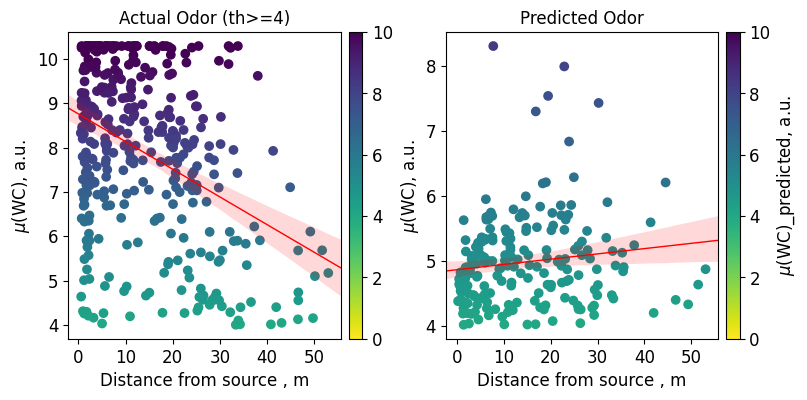

In [119]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var1 = ax1.scatter(fdf.avg_dist_from_source,fdf.mean_concentration, c=fdf.mean_concentration, cmap='viridis_r', vmin=0,vmax=10 )
ax1.set_ylabel('$\mu$(WC), a.u.')


g1 = sns.regplot(x=fdf.avg_dist_from_source,y=fdf.mean_concentration , data=fdf,
            ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var1, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(WC), a.u.')

ax1.set_xlabel('Distance from source , m')
ax1.set_ylabel('$\mu$(WC), a.u.')
ax1.set_title('Actual Odor (th>='+str(th)+')')

var2=ax2.scatter(fdf_predicted.avg_dist_from_source,
              fdf_predicted.mean_concentration, 
              c=fdf_predicted.mean_concentration, cmap='viridis_r',vmin=0,vmax=10 )
# ax2.set_ylabel('Whiff Concentration, a.u.')


g2 = sns.regplot(x=fdf_predicted.avg_dist_from_source,y=fdf_predicted.mean_concentration , data=fdf_predicted,
            ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')

ax2.set_xlabel('Distance from source , m')
# ax2.set_ylabel('$\mu$(WC), a.u.')
ax2.set_title('Predicted Odor')
f.tight_layout(pad=1)

mpl_functions.set_fontsize(f, 12)
# f.savefig('../assets/300_ensemble_full.jpeg', dpi=150, bbox_inches = "tight")

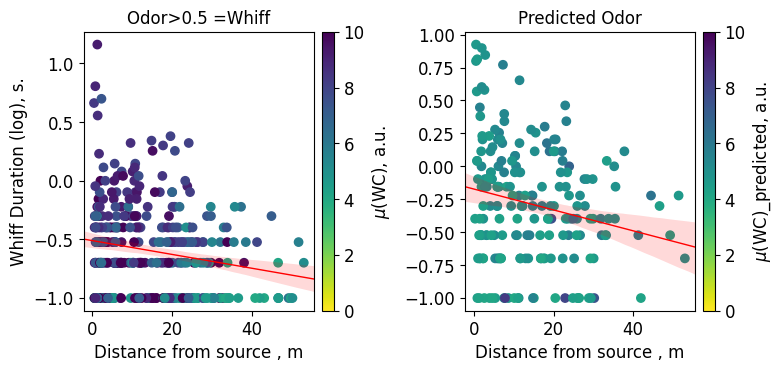

In [120]:
### WHIFF DURATION
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var = ax1.scatter(fdf.avg_dist_from_source,fdf.log_whiff, c=fdf.mean_concentration, cmap='viridis_r',vmin=0,vmax=10  )
ax1.set_ylabel('$\mu$(WC), a.u.')

g1 = sns.regplot(x=fdf.avg_dist_from_source,y=fdf.log_whiff , data=fdf,
            ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(WC), a.u.')

ax1.set_xlabel('Distance from source , m')
ax1.set_title('Odor>0.5 =Whiff')
ax1.set_ylabel('Whiff Duration (log), s.')


u=ax2.scatter(fdf_predicted.avg_dist_from_source,
              fdf_predicted.log_whiff, 
              c=fdf_predicted.mean_concentration, cmap='viridis_r',vmin=0,vmax=10)

g2 = sns.regplot(x=fdf_predicted.avg_dist_from_source,y=fdf_predicted.log_whiff , data=fdf_predicted,
            ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')

# ax2.set_ylabel('Whiff Duration, s')
ax2.set_xlabel('Distance from source , m')
ax2.set_title('Predicted Odor')

f.tight_layout(pad=2)

mpl_functions.set_fontsize(f, 12)

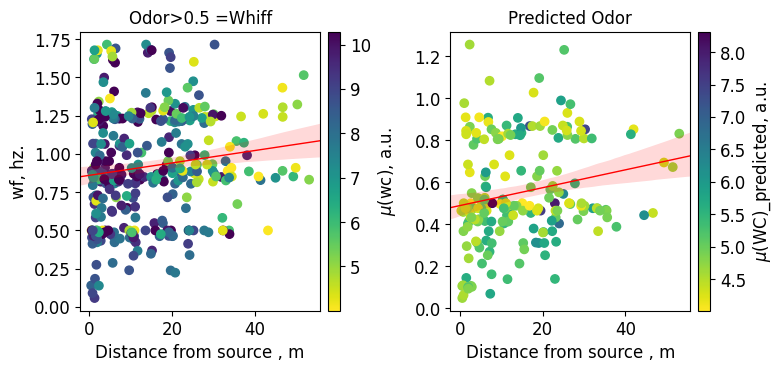

In [121]:
### WHIFF FREQ
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var = ax1.scatter(fdf.avg_dist_from_source,fdf.wf, c=fdf.mean_concentration, cmap='viridis_r' )
ax1.set_ylabel('$\mu$(WC), a.u.')

g1 = sns.regplot(x=fdf.avg_dist_from_source,y=fdf.wf , data=fdf,
            ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(wc), a.u.')

ax1.set_xlabel('Distance from source , m')
ax1.set_title('Odor>0.5 =Whiff')
ax1.set_ylabel('wf, hz.')


u=ax2.scatter(fdf_predicted.avg_dist_from_source,
              fdf_predicted.wf, 
              c=fdf_predicted.mean_concentration, cmap='viridis_r' )

g2 = sns.regplot(x=fdf_predicted.avg_dist_from_source,y=fdf_predicted.wf , data=fdf_predicted,
            ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')

# ax2.set_ylabel('Whiff Duration, s')
ax2.set_xlabel('Distance from source , m')
ax2.set_title('Predicted Odor')

f.tight_layout(pad=2)

mpl_functions.set_fontsize(f, 12)
# f.savefig('../assets/300_ensemble_full.jpeg', dpi=150, bbox_inches = "tight")

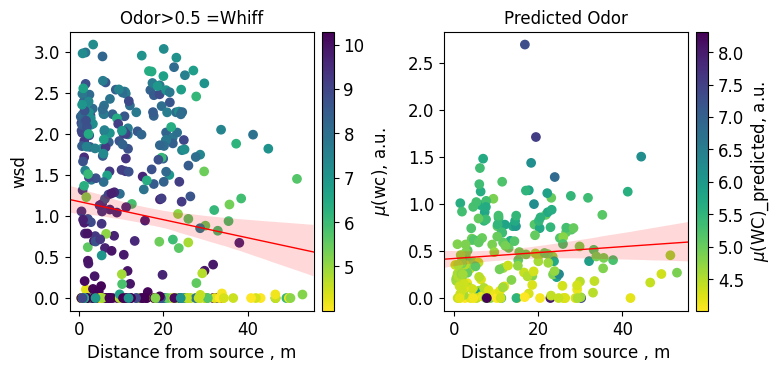

In [122]:
### WSD
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var = ax1.scatter(fdf.avg_dist_from_source,fdf.std_whiff, c=fdf.mean_concentration, cmap='viridis_r' )
ax1.set_ylabel('$\mu$(WC), a.u.')

g1 = sns.regplot(x=fdf.avg_dist_from_source,y=fdf.std_whiff , data=fdf,
            ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(wc), a.u.')

ax1.set_xlabel('Distance from source , m')
ax1.set_title('Odor>0.5 =Whiff')
ax1.set_ylabel('wsd')


u=ax2.scatter(fdf_predicted.avg_dist_from_source,
              fdf_predicted.std_whiff, 
              c=fdf_predicted.mean_concentration, cmap='viridis_r' )

g2 = sns.regplot(x=fdf_predicted.avg_dist_from_source,y=fdf_predicted.std_whiff , data=fdf_predicted,
            ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')

# ax2.set_ylabel('Whiff Duration, s')
ax2.set_xlabel('Distance from source , m')
ax2.set_title('Predicted Odor')

f.tight_layout(pad=2)

mpl_functions.set_fontsize(f, 12)
# f.savefig('../assets/300_ensemble_full.jpeg', dpi=150, bbox_inches = "tight")

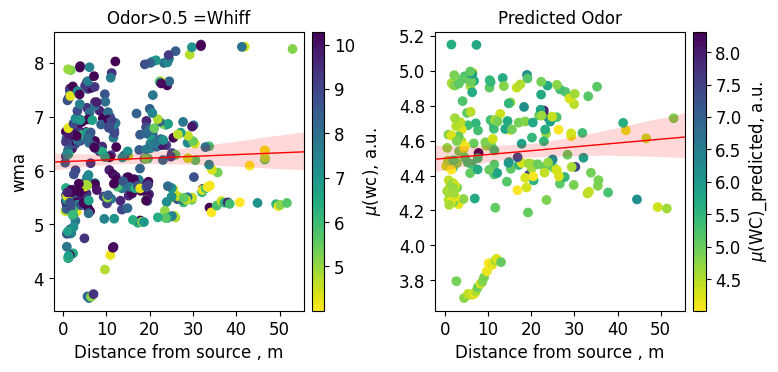

In [123]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var = ax1.scatter(fdf.avg_dist_from_source,fdf.whiff_ma, c=fdf.mean_concentration, cmap='viridis_r' )
ax1.set_ylabel('$\mu$(WC), a.u.')

g1 = sns.regplot(x=fdf.avg_dist_from_source,y=fdf.whiff_ma , data=fdf,
            ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(wc), a.u.')

ax1.set_xlabel('Distance from source , m')
ax1.set_title('Odor>0.5 =Whiff')
ax1.set_ylabel('wma')


u=ax2.scatter(fdf_predicted.avg_dist_from_source,
              fdf_predicted.whiff_ma, 
              c=fdf_predicted.mean_concentration, cmap='viridis_r' )

g2 = sns.regplot(x=fdf_predicted.avg_dist_from_source,y=fdf_predicted.whiff_ma , data=fdf_predicted,
            ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')

# ax2.set_ylabel('Whiff Duration, s')
ax2.set_xlabel('Distance from source , m')
ax2.set_title('Predicted Odor')

f.tight_layout(pad=2)

mpl_functions.set_fontsize(f, 12)
# f.savefig('../assets/300_ensemble_full.jpeg', dpi=150, bbox_inches = "tight")

In [124]:
def create_class_column(dataframe):
    dataframe.loc[dataframe.avg_dist_from_source < 10, 'type'] = 0
    dataframe.loc[(dataframe.avg_dist_from_source >= 10)  & (dataframe.avg_dist_from_source < 20), 'type'] = 1
    dataframe.loc[dataframe.avg_dist_from_source >= 20, 'type'] = 2
    return dataframe

fdf_new = create_class_column(fdf)
fdf_predicted_new = create_class_column(fdf_predicted)

In [125]:
lookback_time = 5

trainset= fdf_new

D_train=[]
mean_time_train=[]
Xtrain = []
ytrain = []
Nrows_train = []

for distance_class in [0,1,2]:
    Xtrain, ytrain, D_train, Nrows_train,mean_time_train = osc.gather_stat_timed(trainset, distance_class,
                      lookback_time, Xtrain, ytrain, D_train, Nrows_train,
                      mean_time_train)
    
def calc_val(X):
    return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])

column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_k',
             'wf_min','wf_max','wf_mean','wf_std_dev','wf_k',
             'wd_min','wd_max','wd_mean','wd_std_dev','wd_k',
             'ma_min','ma_max','ma_mean','ma_std_dev','ma_k',
             'st_min','st_max','st_mean','st_std_dev','st_k']

traindf=pd.DataFrame(columns = column_names)
c1=[]
for i in range(len(Xtrain)):
    if(np.size(Xtrain[i])==0):
        c1.append(i)
        continue
    else:
        X=[]
        for j in range(len(Xtrain[i])):
            X.append(calc_val(Xtrain[i][j]))
        traindf.loc[i]=np.ravel(X)
        
traindf['distance']=np.delete(D_train, c1)
traindf['mean_whiff_time'] = np.delete(mean_time_train, c1)
traindf['nwhiffs'] = np.delete(Nrows_train, c1)

/tmp/ipykernel_1410379/2321856514.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_1410379/2321856514.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_1410379/2321856514.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_1410379/2321856514.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This 

In [126]:
lookback_time = 5

trainset_predicted= fdf_predicted_new
# trainset= fdf_predicted_new

D_train_predicted=[]
mean_time_train_predicted=[]
Xtrain_predicted = []
ytrain_predicted = []
predictions_filled = []
mean_time_train_predicted = []
Nrows_train_predicted = []

for distance_class in [0,1,2]:
    Xtrain_predicted, ytrain_predicted, D_train_predicted, Nrows_train_predicted , mean_time_train_predicted = osc.gather_stat_timed(trainset, distance_class,
                      lookback_time, Xtrain_predicted, ytrain_predicted, D_train_predicted, Nrows_train_predicted,
                      mean_time_train_predicted)
    
def calc_val(X):
    return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])

column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_k',
             'wf_min','wf_max','wf_mean','wf_std_dev','wf_k',
             'wd_min','wd_max','wd_mean','wd_std_dev','wd_k',
             'ma_min','ma_max','ma_mean','ma_std_dev','ma_k',
             'st_min','st_max','st_mean','st_std_dev','st_k']

traindf_predicted=pd.DataFrame(columns = column_names)
c1=[]
for i in range(len(Xtrain)):
    if(np.size(Xtrain[i])==0):
        c1.append(i)
        continue
    else:
        X=[]
        for j in range(len(Xtrain[i])):
            X.append(calc_val(Xtrain[i][j]))
        traindf_predicted.loc[i]=np.ravel(X)
        
traindf_predicted['distance']=np.delete(D_train_predicted, c1)
traindf_predicted['mean_whiff_time'] = np.delete(mean_time_train_predicted, c1)

/tmp/ipykernel_1410379/2500237992.py:20: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_1410379/2500237992.py:20: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_1410379/2500237992.py:20: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_1410379/2500237992.py:20: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This 

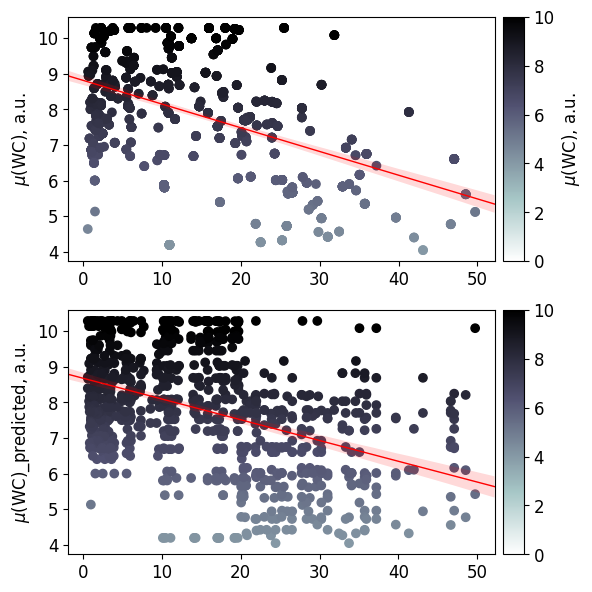

In [127]:
f,ax = plt.subplots(2,1,figsize=(6,6))
var1 =ax[0].scatter(traindf.distance, traindf.mc_mean, c=traindf.mc_mean, cmap='bone_r', vmin=0, vmax=10)


divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')
ax[0].set_ylabel('$\mu$(WC), a.u.')

g1 = sns.regplot(x=traindf.distance,y=traindf.mc_mean, data=traindf,
            ax=ax[0], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)

g1.set(xlabel=None, ylabel=None)

var2 =ax[1].scatter(traindf_predicted.distance, traindf_predicted.mc_mean, c=traindf_predicted.mc_mean, cmap='bone_r', vmin=0, vmax=10)

g2 = sns.regplot(x=traindf_predicted.distance,y=traindf_predicted.mc_mean, data=traindf_predicted,
            ax=ax[1], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
ax[0].set_ylabel('$\mu$(WC), a.u.')
ax[1].set_ylabel('$\mu$(WC)_predicted, a.u.')

mpl_functions.set_fontsize(f, 12)
f.tight_layout(pad=1)


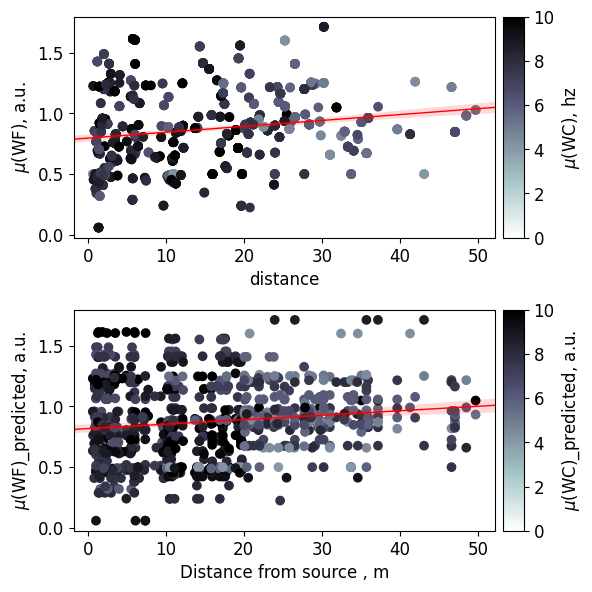

In [130]:
f,ax = plt.subplots(2,1,figsize=(6,6))


var1 =ax[0].scatter(traindf.distance, traindf.wf_mean, c=traindf.mc_mean, cmap='bone_r', vmin=0, vmax=10)

divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), hz')

g1 = sns.regplot(x=traindf.distance,y=traindf.wf_mean, data=traindf,
            ax=ax[0], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)

var2 =ax[1].scatter(traindf_predicted.distance, traindf_predicted.wf_mean,
                    c=traindf_predicted.mc_mean, cmap='bone_r', vmin=0, vmax=10)

g2 = sns.regplot(x=traindf_predicted.distance,y=traindf_predicted.wf_mean, data=traindf_predicted,
            ax=ax[1], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
# g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')

predictions_filled
ax[1].set_xlabel('Distance from source , m')
ax[0].set_ylabel('$\mu$(WF), a.u.')
ax[1].set_ylabel('$\mu$(WF)_predicted, a.u.')

mpl_functions.set_fontsize(f, 12)
f.tight_layout(pad=1)


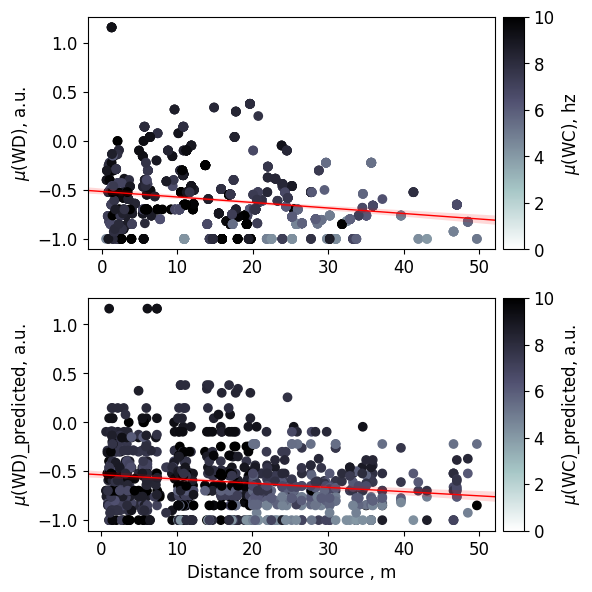

In [131]:
f,ax = plt.subplots(2,1,figsize=(6,6))


var1 =ax[0].scatter(traindf.distance, traindf.wd_mean, c=traindf.mc_mean, cmap='bone_r', vmin=0, vmax=10)

divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), hz')

g1 = sns.regplot(x=traindf.distance,y=traindf.wd_mean, data=traindf, ax=ax[0], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

var2 =ax[1].scatter(traindf_predicted.distance, traindf_predicted.wd_mean,c=traindf_predicted.mc_mean, cmap='bone_r', vmin=0, vmax=10,)

g2 = sns.regplot(x=traindf_predicted.distance,y=traindf_predicted.wd_mean, data=traindf_predicted,
            ax=ax[1], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')


ax[1].set_xlabel('Distance from source , m')
ax[0].set_ylabel('$\mu$(WD), a.u.')
ax[1].set_ylabel('$\mu$(WD)_predicted, a.u.')

mpl_functions.set_fontsize(f, 12)
f.tight_layout(pad=1)


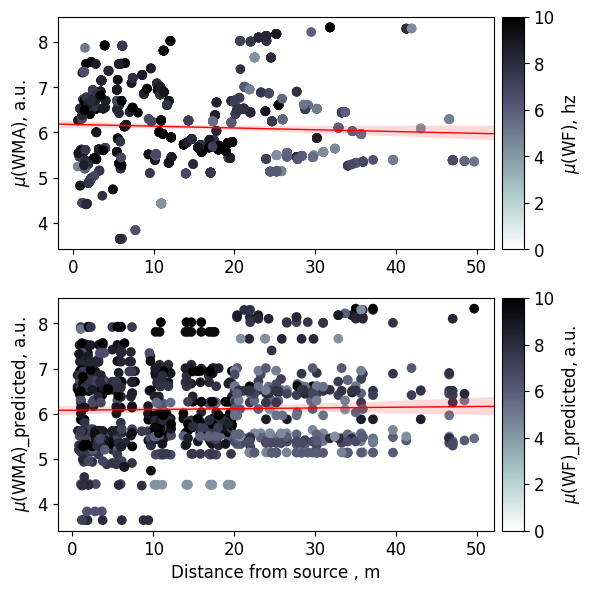

In [135]:
f,ax = plt.subplots(2,1,figsize=(6,6))


var1 =ax[0].scatter(traindf.distance, traindf.ma_mean, c=traindf.mc_mean, cmap='bone_r', vmin=0, vmax=10)

divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WF), hz')

g1 = sns.regplot(x=traindf.distance,y=traindf.ma_mean, data=traindf, ax=ax[0], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

var2 =ax[1].scatter(traindf_predicted.distance, traindf_predicted.ma_mean,c=traindf_predicted.mc_mean, cmap='bone_r', vmin=0, vmax=10,)

g2 = sns.regplot(x=traindf_predicted.distance,y=traindf_predicted.ma_mean, data=traindf_predicted,
            ax=ax[1], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WF)_predicted, a.u.')


ax[1].set_xlabel('Distance from source , m')
ax[0].set_ylabel('$\mu$(WMA), a.u.')
ax[1].set_ylabel('$\mu$(WMA)_predicted, a.u.')

mpl_functions.set_fontsize(f, 12)
f.tight_layout(pad=1)


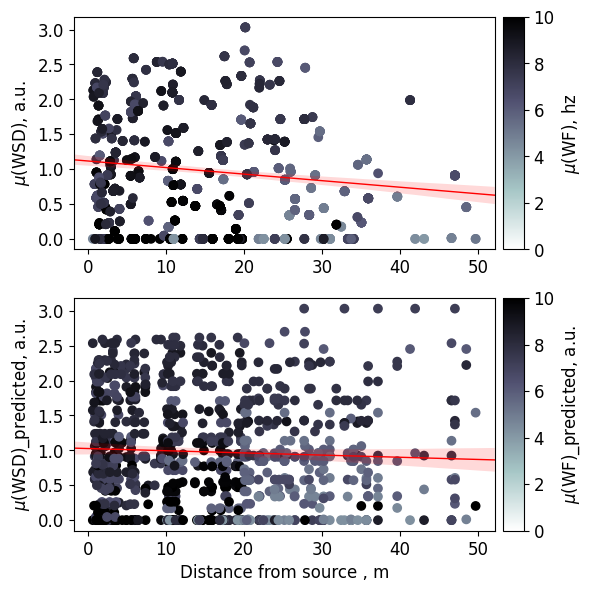

In [134]:
f,ax = plt.subplots(2,1,figsize=(6,6))


var1 =ax[0].scatter(traindf.distance, traindf.st_mean, c=traindf.mc_mean, cmap='bone_r', vmin=0, vmax=10)

divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WF), hz')

g1 = sns.regplot(x=traindf.distance,y=traindf.st_mean, data=traindf, ax=ax[0], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

var2 =ax[1].scatter(traindf_predicted.distance, traindf_predicted.st_mean,c=traindf_predicted.mc_mean, cmap='bone_r', vmin=0, vmax=10,)

g2 = sns.regplot(x=traindf_predicted.distance,y=traindf_predicted.st_mean, data=traindf_predicted,
            ax=ax[1], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WF)_predicted, a.u.')


ax[1].set_xlabel('Distance from source , m')
ax[0].set_ylabel('$\mu$(WSD), a.u.')
ax[1].set_ylabel('$\mu$(WSD)_predicted, a.u.')

mpl_functions.set_fontsize(f, 12)
f.tight_layout(pad=1)
